In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option('display.max_rows', None)       # Показывать все строки
#pd.set_option('display.max_columns', None)    # Показывать все столбцы
#pd.set_option('display.width', None)          # Не ограничивать ширину вывода
#pd.set_option('display.max_colwidth', None)

In [ ]:
df=pd.read_csv('/kaggle/input/sirius/dataset_for_sirius.csv', sep=";")
print(len(df))
num_columns = df.shape[1]
print(f"Количество столбцов: {num_columns}")

593433
Количество столбцов: 246


In [ ]:
df.head()

,expiration_minus_1d_dt,id,target,renewal_amt,one_prc_loyalty_accrual_rub_amt,sovokupnyj_balans,sovokupnye_traty,median_monthly_income_amt,monthly_income_amt,avg_integral_cur_rur_balance,...,diff_gazprombank_6_mean,diff_gazprombank_3_mean,diff_vtb_24_mean,diff_vtb_12_mean,diff_vtb_6_mean,diff_vtb_3_mean,diff_alfa_bank_24_mean,diff_alfa_bank_12_mean,diff_alfa_bank_6_mean,diff_alfa_bank_3_mean
0,2024-03-18,65757,0,<100000,<500,<500000,<50000,<100000,NaN,<50000,...,-0.4825,-0.5050,4.210,0.55,0.010000,0.680,0.217500,1.8375,1.445000,1.490000
1,2024-05-26,302422,0,<1400000,<500,<1400000,NaN,<50000,<500000,<50000,...,-0.3380,-0.9000,4.765,0.61,0.540000,0.425,0.408000,1.6880,1.638000,1.080000
2,2024-02-22,325078,0,<1400000,<500,>=1400000,NaN,<50000,<100000,<10000,...,-0.4825,-0.5050,4.840,-0.02,0.010000,0.680,0.847500,1.2675,1.245000,1.490000
3,2024-01-15,284248,0,<500000,<1000,<1400000,<500000,<500000,NaN,<10000,...,0.7525,1.5425,4.840,-0.02,0.646667,0.680,1.073333,1.8300,1.883333,2.206667
4,2024-02-24,151409,1,<500000,<10000,<500000,<500000,<100000,<500000,<50000,...,-0.4825,-0.5050,4.840,-0.02,0.010000,0.680,0.847500,1.2675,1.245000,1.490000


In [ ]:
df['expiration_minus_1d_dt'] = pd.to_datetime(df['expiration_minus_1d_dt'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Оставляем только одно (максимально свежее) наблюдение на каждый id
df_latest = df.sort_values('expiration_minus_1d_dt').dropna(subset=['id', 'longitude']).groupby('id', as_index=False).last()

# Функция классификации по долготе
def classify_city(lon):
    if pd.isna(lon):
        return 'Мир'
    elif 36.5 <= lon < 38.5:
        return 'Москва'
    elif 29.0 <= lon < 31.0:
        return 'Санкт-Петербург'
    elif 20.0 <= lon < 180.0:
        return 'Россия'
    else:
        return 'Мир'

# Добавляем колонку
df['city_group'] = df['longitude'].apply(classify_city)

In [ ]:
# ──────────────────────────────────────────────────────────────
# 1.  Списки флагов
# ──────────────────────────────────────────────────────────────
loyalty_flags = [
    "Vklad","Nakopitel.nyj_schet","Kubyshka","Investkopilka","IIS",
    "Brokerskij_schet","Popolnjal_brokerskij",
    "Private","Premium","Pro",
    "IFL","Strahovanie_ipoteki","Osago","Kasko","NS_keptivnaja_strahovka","VZR",
    "Poluchaet_ZP","Avtoplatezh",
    "Sovmestnyj_schet","Dopka_na_3_litso","Sharing_scheta","Junior","Biznes_schet",
    "X3._aktivnyh_produkta","Privel_druga","Used_special_offer","used_special_offer",
    "Est._mobajl"
]

loyal_cols = [c for c in loyalty_flags if c in df.columns]

_true  = {1, "1", True, "t", "T"}
_false = {0, "0", False, "f", "F"}

def to_bool(s: pd.Series) -> pd.Series:
    """любое «истинное» значение → 1, всё остальное (включая NA) → 0"""
    return s.isin(_true).astype(int)

def is_binary(series: pd.Series) -> bool:
    uniq = set(series.dropna().unique())
    return uniq.issubset(_true | _false)

binary_flags = [c for c in df.columns if is_binary(df[c])]
other_cols   = [c for c in binary_flags if c not in loyal_cols]

# ──────────────────────────────────────────────────────────────
# 2.  Считаем индексы
# ──────────────────────────────────────────────────────────────
df["loyalty_score"]     = df[loyal_cols].apply(to_bool).sum(axis=1)

df["card_usage_score"]  = (
    df[other_cols]       # все оставшиеся бинарные признаки
      .apply(to_bool)
      .sum(axis=1)
)

# ──────────────────────────────────────────────────────────────
# 3.  Быстрая проверка
# ──────────────────────────────────────────────────────────────
print(df[["loyalty_score", "card_usage_score"]].head())

   loyalty_score  card_usage_score
0              2                15
1              4                 7
2              3                 9
3              1                13
4              7                26


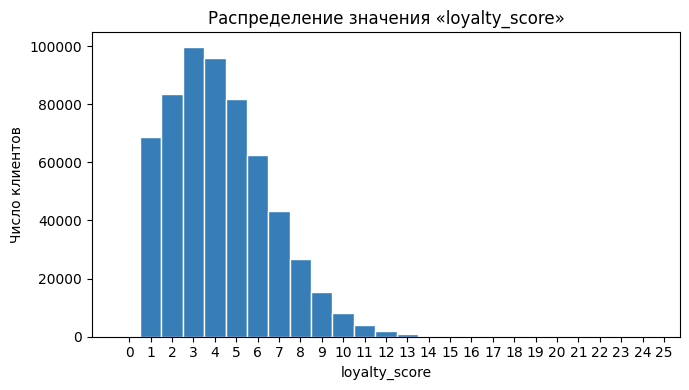

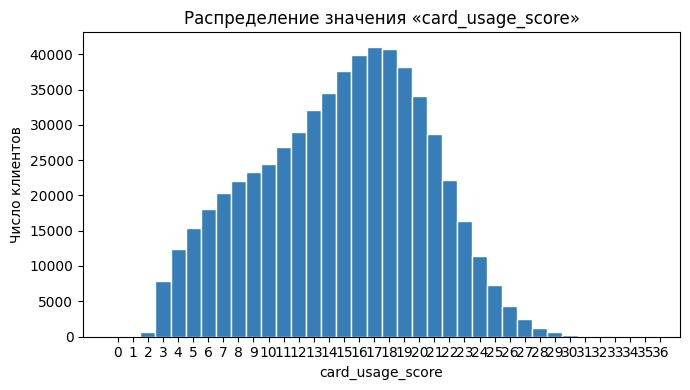

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------
# 1.  Какие числовые колонки хотим посмотреть
# -------------------------------------------------------------
score_cols = ["loyalty_score", "card_usage_score"]

# -------------------------------------------------------------
# 2.  Рисуем гистограмму для каждой колонки
#     (одна фигура = один график, чтобы не было «давки»)
# -------------------------------------------------------------
for col in score_cols:
    data = df[col].dropna()                         # страховка на случай пропусков

    # -- оптимальные «целочисленные» бины
    #    если разброс маленький — рисуем по каждому значению,
    #    иначе берём 30 равных интервалов
    uniq_vals = np.sort(data.unique())
    if (uniq_vals.dtype.kind in "iu") and (len(uniq_vals) < 40):
        bins = np.arange(uniq_vals.min(), uniq_vals.max() + 2)    # «по единичке»
    else:
        bins = 30

    plt.figure(figsize=(7, 4))
    plt.hist(data, bins=bins, color="#377eb8", edgecolor="white", align="left")
    plt.title(f"Распределение значения «{col}»")
    plt.xlabel(col)
    plt.ylabel("Число клиентов")
    if isinstance(bins, np.ndarray):
        plt.xticks(bins)                            # показываем все целые подписи
    plt.tight_layout()
    plt.show()


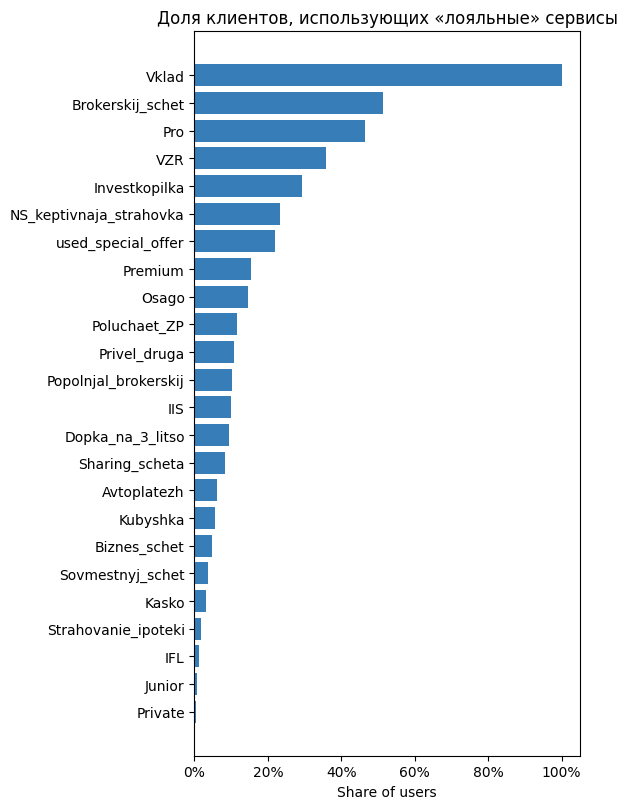

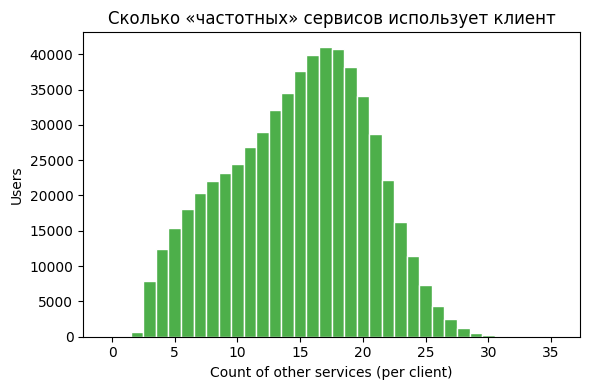

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────
# 0.  Списки флагов
# ──────────────────────────────────────────────────────────────
loyalty_flags = [
    "Vklad", "Nakopitel.nyj_schet", "Kubyshka", "Investkopilka", "IIS",
    "Brokerskij_schet", "Popolnjal_brokerskij",
    "Private", "Premium", "Pro",
    "IFL", "Strahovanie_ipoteki", "Osago", "Kasko", "NS_keptivnaja_strahovka", "VZR",
    "Poluchaet_ZP", "Avtoplatezh",
    "Sovmestnyj_schet", "Dopka_na_3_litso", "Sharing_scheta", "Junior", "Biznes_schet",
    "X3._aktivnyh_produkta", "Privel_druga", "Used_special_offer", "used_special_offer",
    "Est._mobajl"
]

loyal_cols = [c for c in loyalty_flags if c in df.columns]   # присутствуют в датафрейме

# ― вспомогательные наборы значений «TRUE»/«FALSE» ─────────────
_true = {1, "1", True, "t", "T"}
_false = {0, "0", False, "f", "F"}

def is_binary(series: pd.Series) -> bool:
    """Колонка состоит только из значений 0/1/TRUE/FALSE/NA?"""
    uniq = set(series.dropna().unique())
    return uniq.issubset(_true | _false)

binary_flags = [c for c in df.columns if is_binary(df[c])]
other_cols   = [c for c in binary_flags if c not in loyal_cols]

# ──────────────────────────────────────────────────────────────
# 1.  Бар-плот частот «лояльных» сервисов
# ──────────────────────────────────────────────────────────────
def to_bool(s: pd.Series) -> pd.Series:
    """Преобразуем любые формы истины к 1, всего остального (0/NA) к 0."""
    return s.isin(_true).astype(int)

loyal_usage = (
    df[loyal_cols]                        # только нужные флаги
      .apply(lambda col: to_bool(col).mean())   # доля «1» в каждом столбце
      .sort_values()                      # отсортируем для красоты
      .rename_axis("service")
      .reset_index(name="share")
)

plt.figure(figsize=(6, 0.3 * len(loyal_usage) + 1))
plt.barh(loyal_usage["service"], loyal_usage["share"], color="#377eb8")
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:.0%}")
)
plt.title("Доля клиентов, использующих «лояльные» сервисы")
plt.xlabel("Share of users")
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────────
# 2.  Количество «частотных» сервисов на клиента
# ──────────────────────────────────────────────────────────────
df["other_cnt"] = df[other_cols].apply(lambda row: to_bool(row).sum(), axis=1)

plt.figure(figsize=(6, 4))
bins = range(int(df["other_cnt"].max()) + 2)   # по единичным корзинам
plt.hist(df["other_cnt"], bins=bins, color="#4daf4a", edgecolor="white", align="left")
plt.title("Сколько «частотных» сервисов использует клиент")
plt.xlabel("Count of other services (per client)")
plt.ylabel("Users")
plt.tight_layout()
plt.show()

### Замена t f на 1 0 соответственно

In [ ]:
# Проходим по всем столбцам датафрейма
for column in df.columns:
    # Получаем уникальные значения в столбце
    unique_values = df[column].unique()
    # Проверяем, совпадают ли уникальные значения с ['t', 'f'] (без учета порядка)
    if set(unique_values) == {'t', 'f'}:
        # Заменяем 't' на 1 и 'f' на 0
        df[column] = df[column].map({'t': 1, 'f': 0})

# Теперь df содержит замененные значения в соответствующих столбцах

### Обработка кешбека

In [ ]:
# cashback_category_flg - столбец с флагом (0/1), что хотя бы одна категория кешбека выбрана

df['cashback_category_flg'] = (
    df[['first_category', 'second_category', 'third_category']]
    .notna()
    .any(axis=1)
    .astype(int)
)

## Очистка данных

### Удаление избыточных столбцов

In [ ]:
# unique_values = df['tarif_id'].unique()  # массив NumPy
# print(unique_values)
# df = df.drop('tarif_id', axis=1)
# df = df.drop(columns = ['Oplatil_toplivo_v_Tinkoff_Gorod', 'Mobajl_kontaktnyj_nomer', 'gender_rate', 'Vklad','avg_purchase_interchange_fee_amt'])
# df=df.drop(columns=['count_top_friends', 'count_of_open_brk', 'time_since_opened_mob', 'time_since_utilization_brk', 'max_count_of_close_mob', 'min_age', 'delay_m4_cnt', 'accnt_auto_cnt','zkr_open_accnt_cnt','days_cred_use_sum','accnt_rev_cnt'])


#  'max_count_of_close_mob',

In [ ]:
#df=df.drop(columns=[ 'tarif_id', 'Oplatil_toplivo_v_Tinkoff_Gorod', 'Mobajl_kontaktnyj_nomer', 'gender_rate', 'Vklad','avg_purchase_interchange_fee_amt', 'count_top_friends', 'count_of_open_brk', 'time_since_opened_mob', 'time_since_utilization_brk', 'min_age',  'accnt_auto_cnt', 'days_cred_use_sum','accnt_rev_cnt',
#                    "max_days_from_open_dt_min", "out_request_cnt_sum", "out_request_cnt_3", "out_request_cnt_3_sum", "out_request_cnt", "median_friend_lifetime", "mpl_std_time", "authorization_type_cd", "time_zone_delta_tm", "days_from_bki_request_dt_max", "days_from_open_dt_max",  "days_from_open_dt_min", "avg_friend_lifetime", "avg_in_c2c_int_amt", "avg_in_sbp_cnt", "avg_out_request_cnt_3", "avg_purchase_interchange_fee_amt",
#                     "avg_out_request_cnt_3", "avg_purchase_interchange_fee_amt", "avg_out_request_cnt", "longitude"])

In [ ]:
num_columns = df.shape[1]
print(f"Количество столбцов: {num_columns}")

Количество столбцов: 251


### Замена выбросов

In [ ]:
df.age = df.age.fillna(df.age.median())
df = df[df.age >=14]



df.use_union_month_cnt = df.use_union_month_cnt.fillna(df.use_union_month_cnt.median())
df.use_union_month_cnt = np.where(
    df.use_union_month_cnt > 228,
    df.use_union_month_cnt.median(),
    df.use_union_month_cnt)

df.use_sum_month_12_cnt = df.use_sum_month_12_cnt.fillna(df.use_sum_month_12_cnt.median())
df.use_sum_month_12_cnt = np.where(
    df.use_sum_month_12_cnt > 12,
    df.use_sum_month_12_cnt.median(),
    df.use_sum_month_12_cnt)

df.max_count_of_close_mob = df.max_count_of_close_mob.fillna(df.use_sum_month_12_cnt.median())
df.max_count_of_close_mob = np.where(
    df.max_count_of_close_mob > df.max_count_of_close_mob.quantile(0.99),
    df.use_sum_month_12_cnt.median(),
    df.use_sum_month_12_cnt)

df.count_of_utils_mob = df.count_of_utils_mob.fillna(df.count_of_utils_mob.median())
df = df[~(df.count_of_utils_mob == 55.0)]

df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.fillna(df.count_of_ever_opened_ccr.median())
df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.replace({43.0: df.count_of_ever_opened_ccr.median()})

df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.fillna(df.count_of_ever_opened_ccr.median())
df.count_of_ever_opened_ccr = df.count_of_ever_opened_ccr.replace({43.0: df.count_of_ever_opened_ccr.median()})


df.full_time_mob = df.full_time_mob.fillna(df.full_time_mob.median())

df.count_of_ever_opened_tcn = df.count_of_ever_opened_tcn.fillna(df.count_of_ever_opened_tcn.median())

df.count_of_all_open = df.count_of_all_open.fillna(df.count_of_all_open.median())

df.delay_m4_cnt = df.delay_m4_cnt.fillna(df.delay_m4_cnt.median())

df.zkr_open_accnt_cnt = df.zkr_open_accnt_cnt.fillna(df.zkr_open_accnt_cnt.median())




In [ ]:

# Sasha

df.iloc[:, 132] = df.iloc[:, 132].abs()
df.iloc[:, 132] = df.iloc[:, 132].fillna(df.iloc[:, 132].median())
df.iloc[:, 133] = df.iloc[:, 133].abs()
df.iloc[:, 133] = df.iloc[:, 133].fillna(df.iloc[:, 133].median())
df.iloc[:, 135] = df.iloc[:, 135].fillna(df.iloc[:, 135].median())
df.iloc[:, 137] = df.iloc[:, 137].fillna(df.iloc[:, 137].median())
df.iloc[:, 138] = df.iloc[:, 138].fillna(df.iloc[:, 138].median())

### Объединение столбцов с подписками (Pro, Premium, Private)

In [ ]:
# df['Account_Type'] = np.select(
#     condlist=[
#         df['Pro'] == 1,
#         df['Premium'] == 1,
#         df['Private'] == 1
#     ],
#     choicelist=[1, 2, 3],
#     default=0  # если ни одно условие не выполнилось
# )

# Удаляем старые столбцы
#df = df.drop(['Private', 'Premium', 'Pro'], axis=1)

### Замена категориальных значений сумм

In [ ]:
for col in ['renewal_amt', 'one_prc_loyalty_accrual_rub_amt', 'sovokupnyj_balans', 'sovokupnye_traty'
    , 'median_monthly_income_amt', 'monthly_income_amt', 'avg_integral_cur_rur_balance', 'avg_out_puc'
    , 'credit_amt_norm_cls_max']:
    unique_values = df[col].unique()  # массив NumPy

    # print()
    # print(col)
    # print(list(unique_values))
    # print(df[col].isna().sum())

    df[col] = df[col].map(
        {'<500': 0, '<1000': 1, '<10000': 2, '<50000': 20, '<100000': 100, '<500000': 200, '<1400000': 1000,
         '>=1400000': 2800})

    median_value = df[col].dropna().median()
    # print(f"Медиана (NaN удалены вручную): {median_value}")
    # print()
    df[col] = df[col].fillna(median_value)

# print(df.head())

### Агрегация полей с суммой кешбека по категория

In [ ]:
cashback_sum = ['sum_second_category', 'sum_third_category']
df['sum_cashback_categ'] = df[['sum_second_category', 'sum_third_category']].sum(axis = 1)
df = df.drop(columns = cashback_sum)
df.loc[df['sum_cashback_categ'] < 0, 'sum_cashback_categ'] = 0

In [ ]:
pos_val = df['target_cashback_amt'][df['target_cashback_amt'] >= 0]
median = pos_val.median()
df['target_cashback_amt'] = df['target_cashback_amt'].where(df['target_cashback_amt'] >= 0, median)
df['target_cashback_amt'] = df['target_cashback_amt'].where(df['target_cashback_amt'] <= 3960, median)

In [ ]:
pos_val = df['target_lifestyle_cashback_amt'][df['target_lifestyle_cashback_amt'] >= 0]
median = pos_val.median()
df['target_lifestyle_cashback_amt'] = df['target_lifestyle_cashback_amt'].where(df['target_lifestyle_cashback_amt'] >= 0, median)
df['target_lifestyle_cashback_amt'] = df['target_lifestyle_cashback_amt'].where(df['target_lifestyle_cashback_amt'] <= 454, median)

In [ ]:
pos_val = df['target_merch_cashback_amt'][df['target_merch_cashback_amt'] >= 0]
median = pos_val.median()
df['target_merch_cashback_amt'] = df['target_merch_cashback_amt'].where(df['target_merch_cashback_amt'] >= 0, median)
df['target_merch_cashback_amt'] = df['target_merch_cashback_amt'].where(df['target_merch_cashback_amt'] <= 2796, median)

In [ ]:
pos_val = df['target_bnk_cashback_amt'][df['target_bnk_cashback_amt'] >= 0]
median = pos_val.median()
df['target_bnk_cashback_amt'] = df['target_bnk_cashback_amt'].where(df['target_bnk_cashback_amt'] >= 0, median)
df['target_bnk_cashback_amt'] = df['target_bnk_cashback_amt'].where(df['target_bnk_cashback_amt'] <= 1652, median)

In [ ]:
target_cashback_sum = ['target_cashback_amt', 'target_lifestyle_cashback_amt', 'target_merch_cashback_amt', 'target_bnk_cashback_amt']
df['sum_cashback_target'] = df[target_cashback_sum].sum(axis = 1)
df = df.drop(columns = target_cashback_sum)

In [ ]:
pos_val = df['high_category_loyalty_accrual_rub_amt'][df['high_category_loyalty_accrual_rub_amt'] >= 0]
median = pos_val.median()
df['high_category_loyalty_accrual_rub_amt'] = df['high_category_loyalty_accrual_rub_amt'].where(df['high_category_loyalty_accrual_rub_amt'] >= 0, median)
df['high_category_loyalty_accrual_rub_amt'] = df['high_category_loyalty_accrual_rub_amt'].where(df['high_category_loyalty_accrual_rub_amt'] <= 5213, median)

In [ ]:
pos_val = df['high_category_loyalty_accrual_bns_amt'][df['high_category_loyalty_accrual_bns_amt'] >= 0]
median = pos_val.median()
df['high_category_loyalty_accrual_bns_amt'] = df['high_category_loyalty_accrual_bns_amt'].where(df['high_category_loyalty_accrual_bns_amt'] >= 0, median)
df['high_category_loyalty_accrual_bns_amt'] = df['high_category_loyalty_accrual_bns_amt'].where(df['high_category_loyalty_accrual_bns_amt'] <= 795, median)

### Группируем флаги страховок в один столбец, дропаем

In [ ]:
insurance_columns = ['IFL', 'Strahovanie_ipoteki', 'Kasko', 'VZR', 'Osago', 'NS_keptivnaja_strahovka']
for column in insurance_columns:
    counts = df[column].value_counts(dropna = False)
    # print(counts)
    nan_count = df[column].isna().sum()
    # print(nan_count)
df['insurance'] = df[insurance_columns].sum(axis = 1)

df = df.drop(columns = insurance_columns)


### Группируем флаги транзакций в один столбец, дропаем

In [ ]:
transactions_columns = ['Oteli', 'Karshering', 'Travel', 'Oplatil_shtraf', 'LifeStyle', 'ZhKH', 'Taksi'
                , 'Zapravki', 'Dostavka_edy', 'Odezhda_elektronika', 'Ecom', 'Obschestvennyj_transport'
                , 'Internet', "Mobil'naja_svjaz'", 'Kafe_restorany_fastfud', 'Onlajn_tranzaktsija'
                , 'Supermarket']

for column in transactions_columns:
    counts = df[column].value_counts(dropna = False)
    # print(counts)
    nan_count = df[column].isna().sum()
    # print(nan_count)
df['transactions'] = df[transactions_columns].sum(axis = 1)

df = df.drop(columns = transactions_columns)


In [ ]:
df.head()

In [ ]:
percentiles = df['renewal_cnt'].quantile([0.5, 0.9, 0.95, 0.99])
print("Процентили renewal_cnt:")
print(percentiles)

median_value = df['renewal_cnt'].dropna().median()
# Заменяем значения > 6 на медиану
df['renewal_cnt'] = df['renewal_cnt'].apply(lambda x: median_value if x > 6 else x)

In [ ]:
num_columns = df.shape[1]
print(f"Количество столбцов: {num_columns}")

In [ ]:
import pandas as pd
from functools import reduce

# --- 0. подготовка -----------------------------------------------------------
df["expiration_minus_1d_dt"] = pd.to_datetime(df["expiration_minus_1d_dt"])

# корзинки по сроку вклада (месяцы)
bucket_bins    = [0, 3, 6, 12, df["months_cnt"].max() + 1]
bucket_labels  = ["0_3", "4_6", "7_12", "12_plus"]
df["duration_bucket"] = pd.cut(
    df["months_cnt"].fillna(0),
    bins=bucket_bins,
    labels=bucket_labels,
    right=True,           # 3 идёт в "0-3", 6 - в "4-6", 12 - в "7-12"
    include_lowest=True)

# --- 1. социо-демо и баллы: последняя запись клиента -------------------------
soc_cols = ["id", "gender_cd", "age", "city_group",
            "loyalty_score", "card_usage_score"]

soc_df = (df
          .sort_values("expiration_minus_1d_dt")
          .drop_duplicates("id", keep="last")[soc_cols]
          .set_index("id"))

# --- 2. агрегаты по пользователю ---------------------------------------------
# 2.1. общее кол-во вкладов + закрытые
agg_total = (df
             .groupby("id")
             .agg(total_deposits = ("id",     "size"),
                  closed_deposits = ("target", lambda x: (x == 1).sum())))
agg_total["closed_ratio"] = (
    agg_total["closed_deposits"] / agg_total["total_deposits"]
)

# 2.2. кол-во вкладов по «корзинкам» срока
deposits_by_bucket = (df
                      .groupby(["id", "duration_bucket"])
                      .size()
                      .unstack(fill_value=0)
                      .add_prefix("deposits_"))

# 2.3. renewal_cnt
renewal_cnt_total  = df.groupby("id")["renewal_cnt"].sum().rename("renewal_cnt_total")
renewal_cnt_bucket = (df
                      .groupby(["id", "duration_bucket"])["renewal_cnt"]
                      .sum()
                      .unstack(fill_value=0)
                      .add_prefix("renewal_cnt_"))

# 2.4. renewal_amt
renewal_amt_total  = df.groupby("id")["renewal_amt"].sum().rename("renewal_amt_total")
renewal_amt_bucket = (df
                      .groupby(["id", "duration_bucket"])["renewal_amt"]
                      .sum()
                      .unstack(fill_value=0)
                      .add_prefix("renewal_amt_"))

# 2.5. совокупный баланс и траты
sov_bal_total  = df.groupby("id")["sovokupnyj_balans"].sum().rename("sov_bal_total")
sov_bal_bucket = (df
                  .groupby(["id", "duration_bucket"])["sovokupnyj_balans"]
                  .sum()
                  .unstack(fill_value=0)
                  .add_prefix("sov_bal_"))

sov_traty_total  = df.groupby("id")["sovokupnye_traty"].sum().rename("sov_traty_total")
sov_traty_bucket = (df
                    .groupby(["id", "duration_bucket"])["sovokupnye_traty"]
                    .sum()
                    .unstack(fill_value=0)
                    .add_prefix("sov_traty_"))

# --- 3. собираем всё в один датафрейм ----------------------------------------
dfs = [soc_df,
       agg_total,
       deposits_by_bucket,
       renewal_cnt_total, renewal_cnt_bucket,
       renewal_amt_total, renewal_amt_bucket,
       sov_bal_total,    sov_bal_bucket,
       sov_traty_total,  sov_traty_bucket]

user_df = reduce(lambda l, r: l.join(r, how="left"), dfs).reset_index()

/tmp/ipykernel_35/125624369.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["id", "duration_bucket"])
/tmp/ipykernel_35/125624369.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["id", "duration_bucket"])["renewal_cnt"]
/tmp/ipykernel_35/125624369.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["id", "duration_bucket"])["renewal_amt"]
/tmp/ipykernel_35/125624369.py:62: FutureWa

In [ ]:
user_df.to_csv("/kaggle/working/user_df.csv", encoding="utf-8")

In [ ]:
# === ОПИСАТЕЛЬНАЯ СТАТИСТИКА ПО ВСЕМ ПОЛЯМ ================================
import numpy as np
import pandas as pd

def full_describe(data: pd.DataFrame) -> pd.DataFrame:
    """
    Возвращает расширенное описание датафрейма:
    • тип переменной
    • количество ненулевых / доля пропусков
    • базовую «describe»-статистику для числовых,
      а для категориальных — число уникальных, top и freq
    """
    # базовое .describe() сразу по всем типам
    desc = data.describe(include="all").T

    # дополнительные признаки
    desc["dtype"]        = data.dtypes
    desc["non_null"]     = data.notna().sum()
    desc["missing_pct"]  = (1 - desc["non_null"] / len(data)).round(3)

    # аккуратно упорядочим столбцы
    cols = (["dtype", "non_null", "missing_pct"] +
            [c for c in desc.columns if c not in ("dtype", "non_null", "missing_pct")])
    return desc[cols]

# --------------------------------------------------------------
stat_df = full_describe(user_df)      # df — ваш исходный датафрейм
print(stat_df)          # вывод первых 20 строк в ячейке


                       dtype  non_null  missing_pct     count unique     top  \
id                     int64    409893        0.000  409893.0    NaN     NaN   
gender_cd             object    409197        0.002    409197      2       F   
age                  float64    409893        0.000  409893.0    NaN     NaN   
city_group            object    409893        0.000    409893      4  Россия   
loyalty_score          int64    409893        0.000  409893.0    NaN     NaN   
card_usage_score       int64    409893        0.000  409893.0    NaN     NaN   
total_deposits         int64    409893        0.000  409893.0    NaN     NaN   
closed_deposits        int64    409893        0.000  409893.0    NaN     NaN   
closed_ratio         float64    409893        0.000  409893.0    NaN     NaN   
deposits_0_3           int64    409893        0.000  409893.0    NaN     NaN   
deposits_4_6           int64    409893        0.000  409893.0    NaN     NaN   
deposits_7_12          int64    409893  

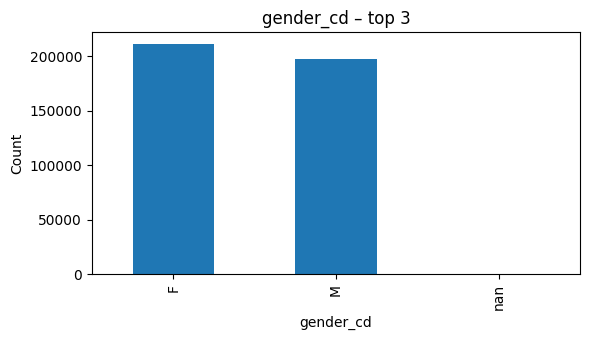

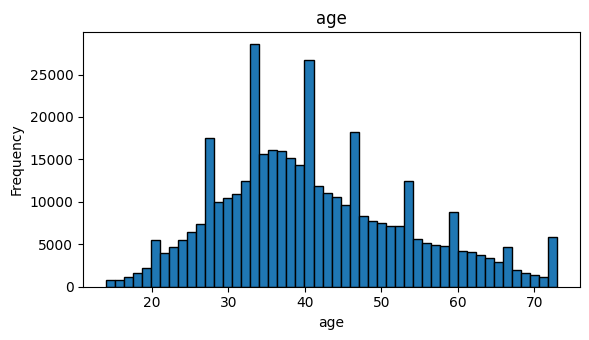

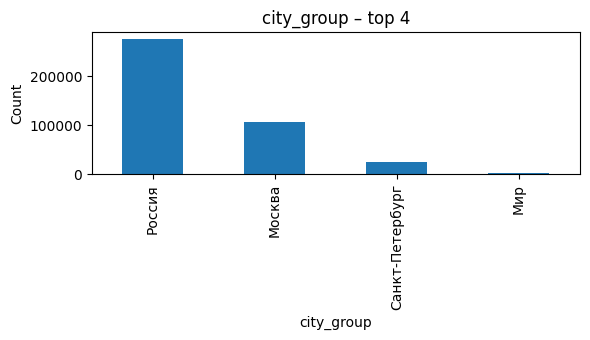

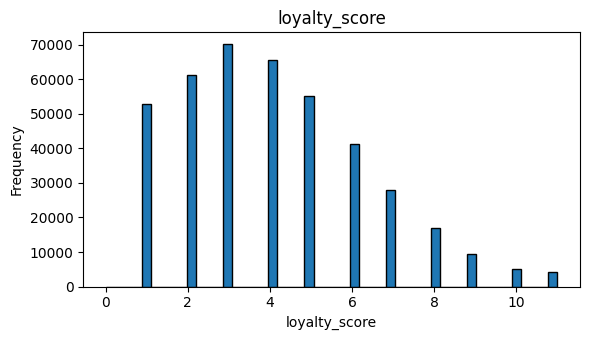

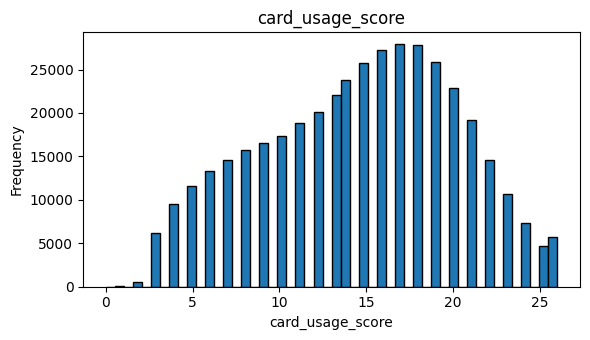

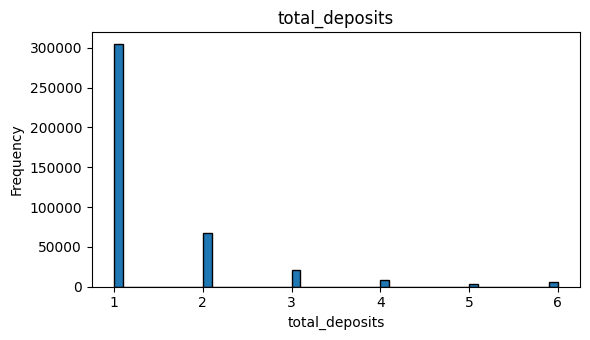

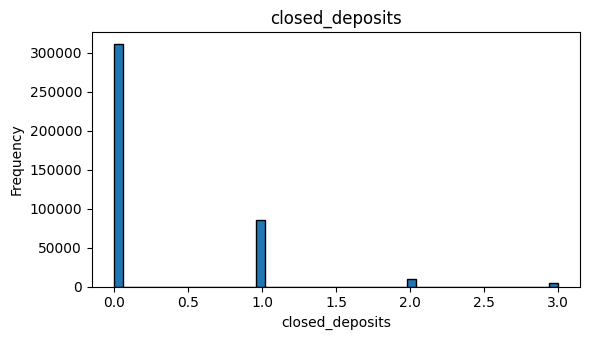

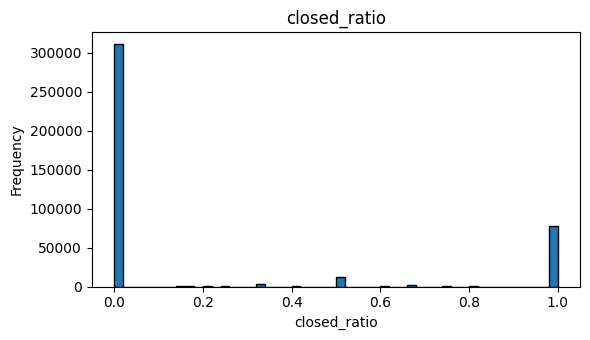

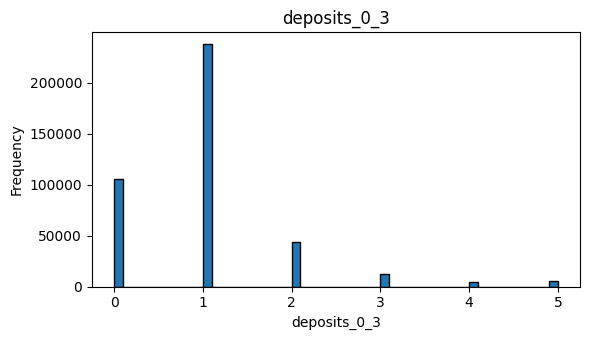

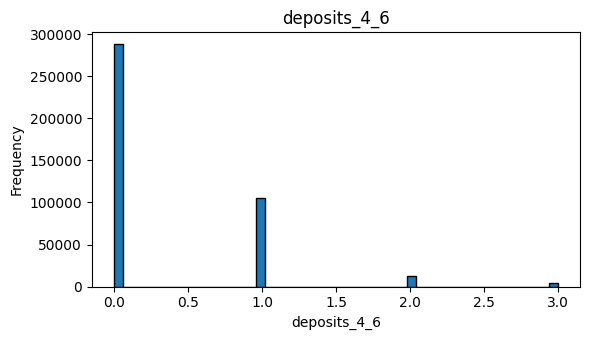

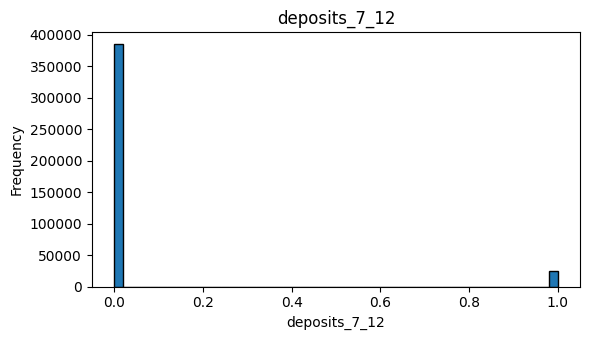

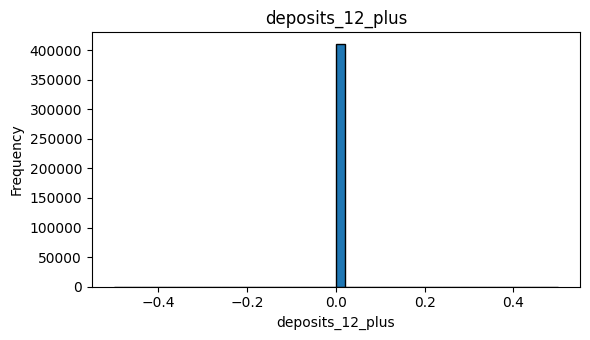

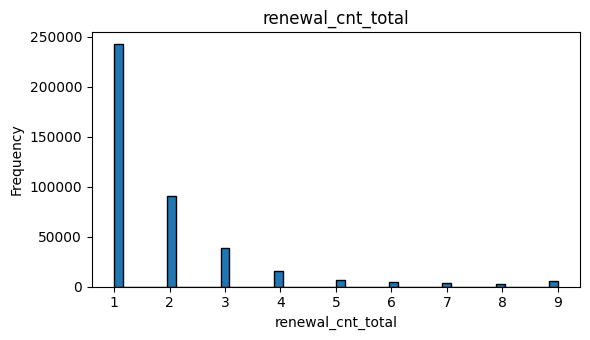

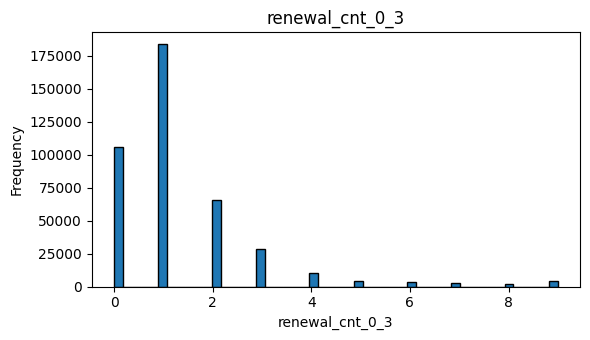

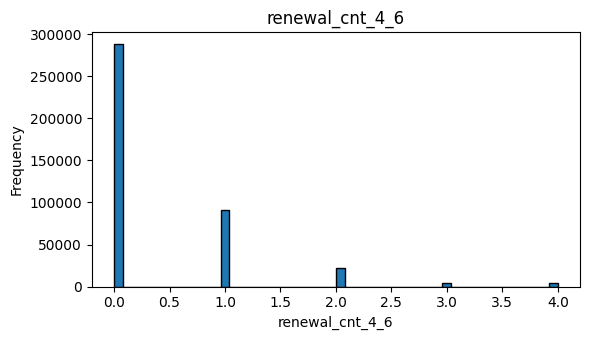

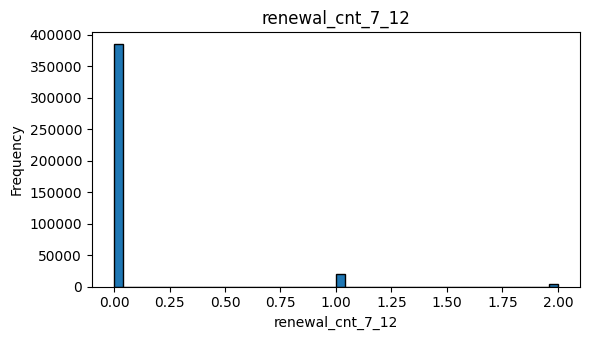

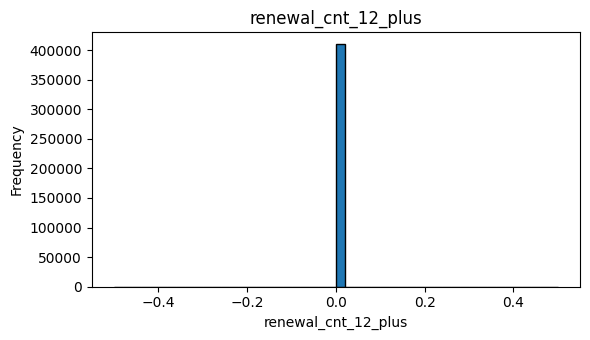

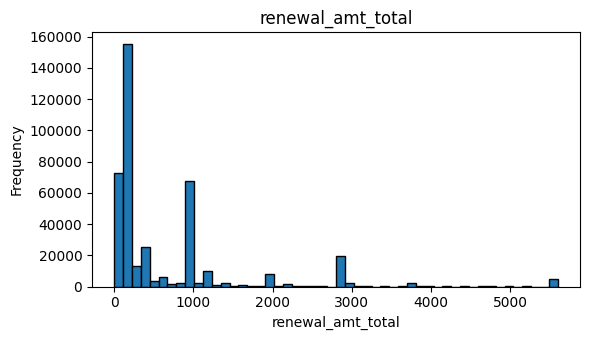

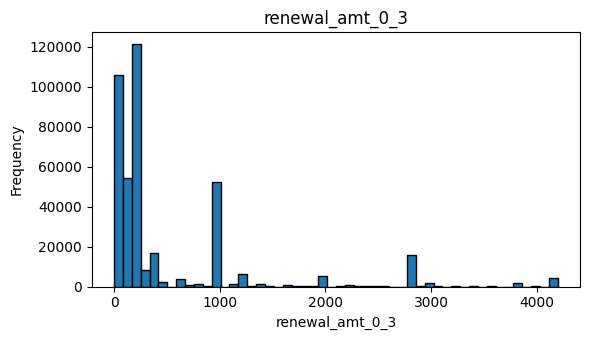

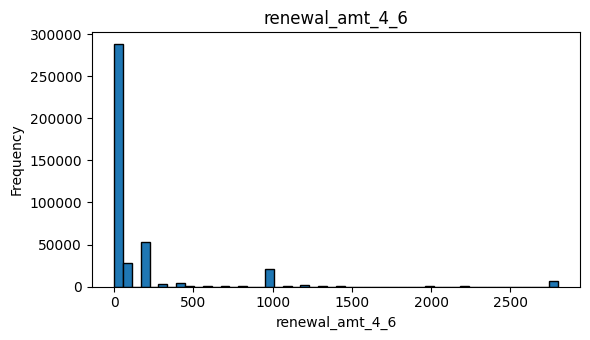

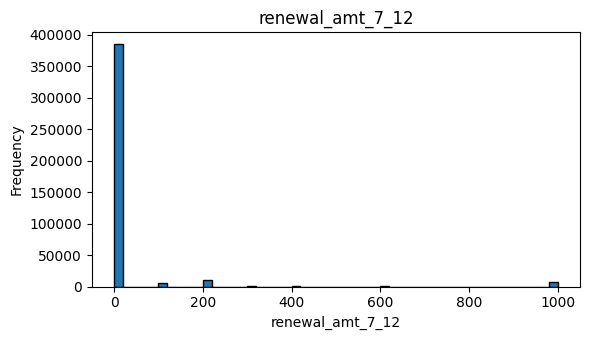

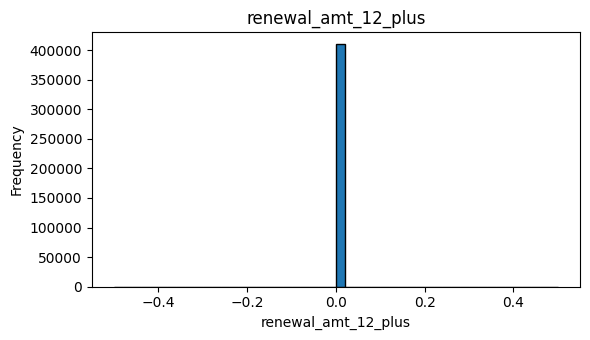

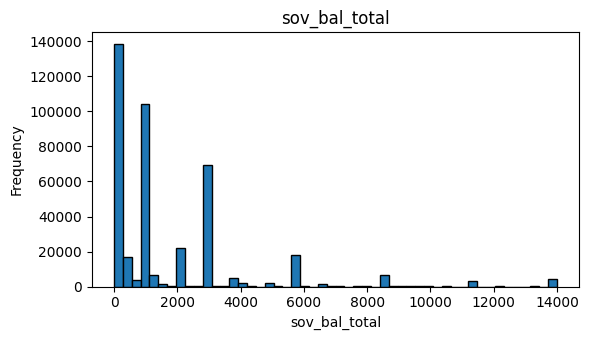

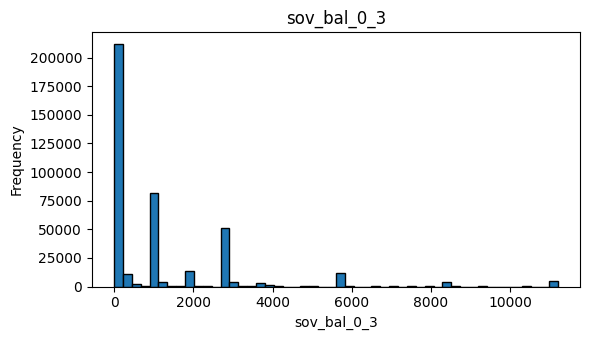

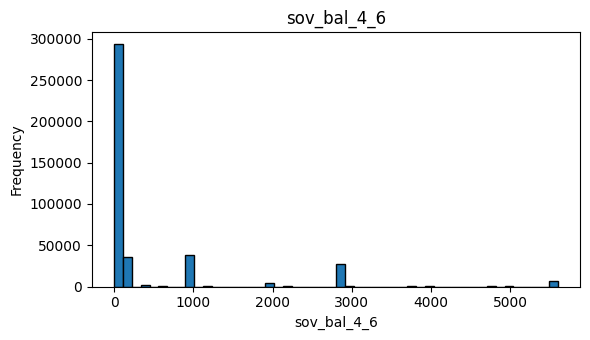

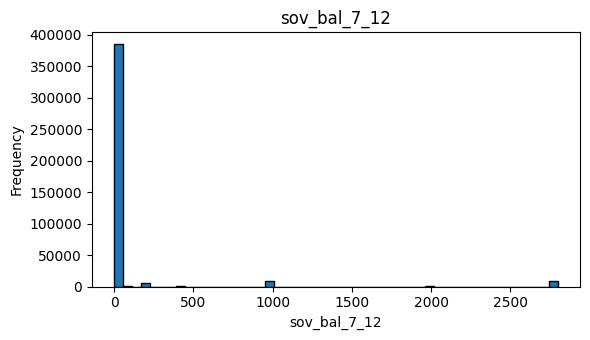

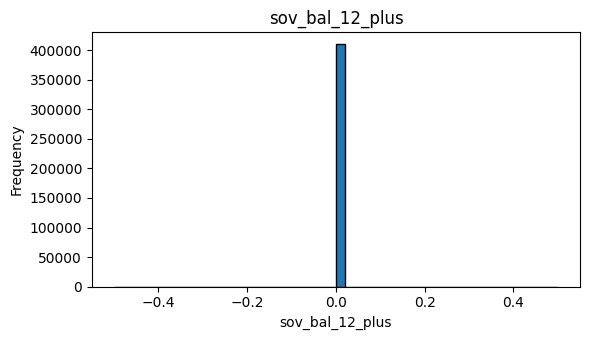

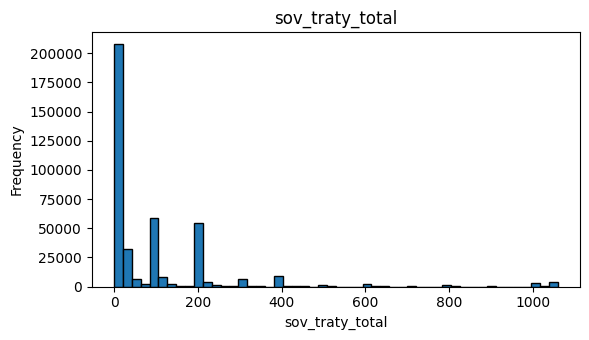

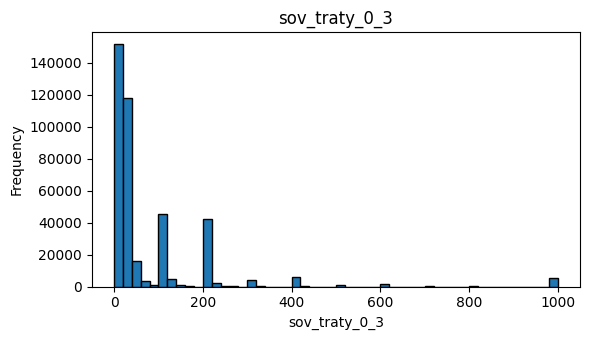

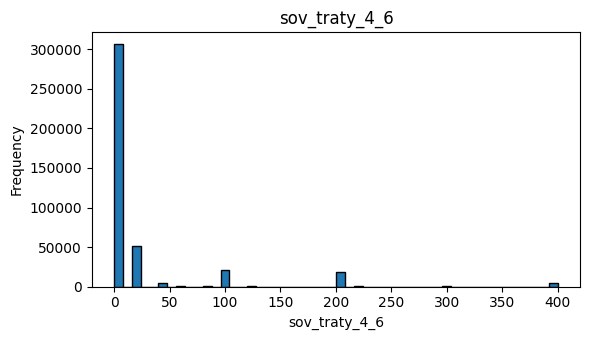

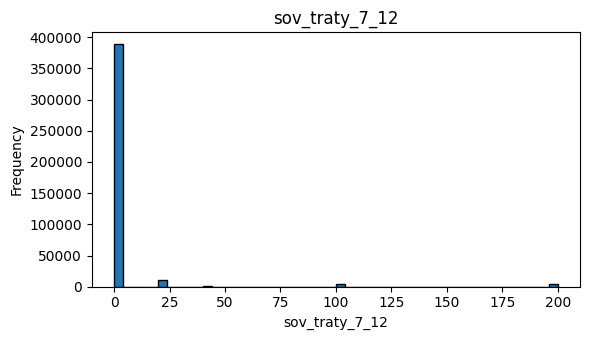

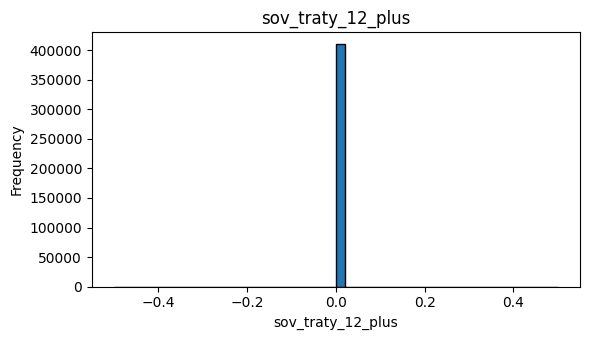

In [ ]:
def plot_numeric(series, name, bins=50, clip_q=0.99):
    """Гистограмма числовой переменной с отсечкой по верхнему quantile."""
    s = series.replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return
    s = np.clip(s, None, np.nanquantile(s, clip_q))   # убираем длинный хвост
    plt.figure(figsize=(6, 3.5))
    plt.hist(s, bins=bins, edgecolor="black")
    plt.title(name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_categorical(series, name, top_n=20):
    """Bar-plot для категориального столбца (top_n частых категорий)."""
    vc = series.astype(str).value_counts().head(top_n)
    if vc.empty:
        return
    plt.figure(figsize=(6, 3.5))
    vc.plot(kind="bar")
    plt.title(f"{name} – top {len(vc)}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------
# идём по всем колонкам и показываем графики сразу в ноутбуке
# ---------------------------------------------------------------
for col in user_df.columns:
    if col in ["id"]:               # id обычно не имеет смысла
        continue

    if pd.api.types.is_numeric_dtype(user_df[col]):
        plot_numeric(user_df[col], col)
    else:
        plot_categorical(user_df[col], col)

In [ ]:
user_df.columns

Index(['id', 'gender_cd', 'age', 'city_group', 'loyalty_score',
       'card_usage_score', 'total_deposits', 'closed_deposits', 'closed_ratio',
       'deposits_0_3', 'deposits_4_6', 'deposits_7_12', 'deposits_12_plus',
       'renewal_cnt_total', 'renewal_cnt_0_3', 'renewal_cnt_4_6',
       'renewal_cnt_7_12', 'renewal_cnt_12_plus', 'renewal_amt_total',
       'renewal_amt_0_3', 'renewal_amt_4_6', 'renewal_amt_7_12',
       'renewal_amt_12_plus', 'sov_bal_total', 'sov_bal_0_3', 'sov_bal_4_6',
       'sov_bal_7_12', 'sov_bal_12_plus', 'sov_traty_total', 'sov_traty_0_3',
       'sov_traty_4_6', 'sov_traty_7_12', 'sov_traty_12_plus'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# 2. числовые признаки для кластеризации
num_cols = [
    'loyalty_score','card_usage_score',
    'total_deposits','closed_deposits','closed_ratio',
    'deposits_0_3','deposits_4_6','deposits_7_12','deposits_12_plus',
    'renewal_cnt_total','renewal_amt_total',
    'sov_bal_total','sov_traty_total'
]

user_df=pd.read_csv('/kaggle/input/sirius-clasterization/user_df.csv', sep=",")

user_df.head()

X = user_df[num_cols].astype(float)






In [ ]:
# 3. масштабирование
X_scaled = StandardScaler().fit_transform(X)

# 4. PCA до 95 % дисперсии
pca = PCA(0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# 5. ищем k по силуэту (быстрый цикл)
best_k, best_score = None, -1
for k in range(3, 11):
    mbkm = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096)
    labels = mbkm.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels, sample_size=10000)  # subsample for speed
    if score > best_score:
        best_k, best_score = k, score

print(f"Best k = {best_k}, silhouette = {best_score:.3f}")



/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: 

Best k = 4, silhouette = 0.251


In [ ]:
# 6. финальная модель
model = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=4096)
user_df["cluster"] = model.fit_predict(X_pca)



/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# 7. быстрый профиль
profile = user_df.groupby("cluster")[num_cols].median().round(1)
print(profile)

         loyalty_score  card_usage_score  total_deposits  closed_deposits  \
cluster                                                                     
0                  6.0              19.0             2.0              0.0   
1                  3.0              13.0             1.0              0.0   
2                  5.0              17.0             5.0              0.0   
3                  4.0              15.0             1.0              1.0   

         closed_ratio  deposits_0_3  deposits_4_6  deposits_7_12  \
cluster                                                            
0                 0.0           1.0           0.0            0.0   
1                 0.0           1.0           0.0            0.0   
2                 0.0           4.0           0.0            0.0   
3                 1.0           1.0           0.0            0.0   

         deposits_12_plus  renewal_cnt_total  renewal_amt_total  \
cluster                                                      

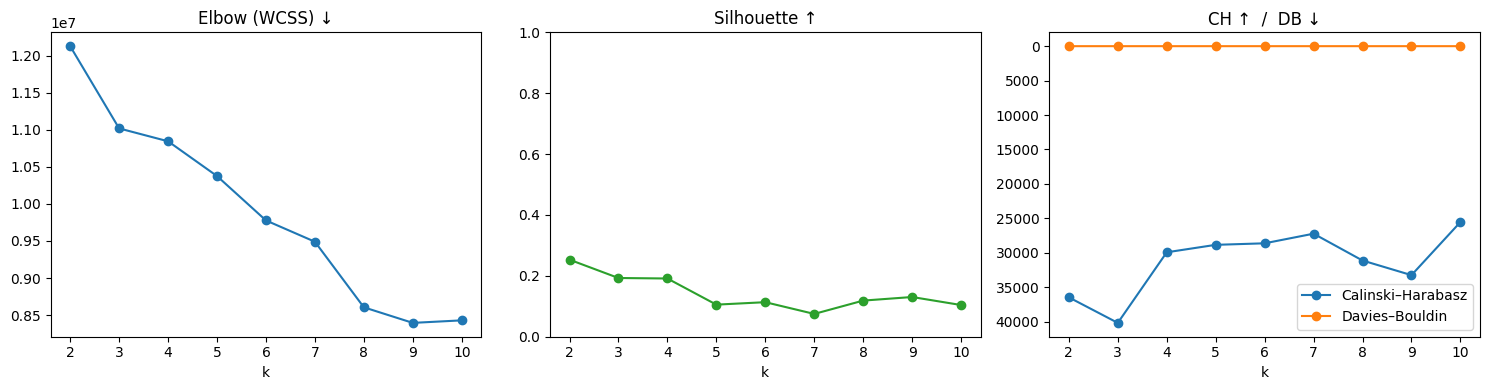

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
import matplotlib.pyplot as plt

# ----- 0) готовим данные ----------------------------------------------------
num_cols = [c for c in user_df.columns if user_df[c].dtype != "O" and c != "id"]
X = StandardScaler().fit_transform(user_df[num_cols])

# ----- 1) выбираем диапазон k ----------------------------------------------
k_range = range(2, 11)
results  = {"k": [], "wcss": [], "silhouette": [], "CH": [], "DB": []}

# ----- 2) цикл по k ---------------------------------------------------------
for k in k_range:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
        batch_size=4096         # подбирайте под своё «железо»
    ).fit(X)

    labels = km.labels_
    results["k"].append(k)
    results["wcss"].append(km.inertia_)
    results["CH"].append(calinski_harabasz_score(X, labels))
    results["DB"].append(davies_bouldin_score(X, labels))

    # Silhouette – только на 5 000 случайных строк (чтобы не «умереть»)
    sample_idx = np.random.choice(X.shape[0], size=5_000, replace=False)
    results["silhouette"].append(
        silhouette_score(X[sample_idx], labels[sample_idx])
    )

res = pd.DataFrame(results)

# ----- 3) визуализация ------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(res["k"], res["wcss"], marker="o")
ax[0].set_title("Elbow (WCSS) ↓");      ax[0].set_xlabel("k")

ax[1].plot(res["k"], res["silhouette"], marker="o", color="tab:green")
ax[1].set_title("Silhouette ↑");        ax[1].set_xlabel("k"); ax[1].set_ylim(0,1)

ax[2].plot(res["k"], res["CH"], marker="o", label="Calinski–Harabasz")
ax[2].plot(res["k"], res["DB"], marker="o", label="Davies–Bouldin")
ax[2].invert_yaxis()                   # DB: «меньше – лучше»
ax[2].set_title("CH ↑  /  DB ↓");      ax[2].set_xlabel("k")
ax[2].legend()

plt.tight_layout(); plt.show()


In [ ]:
# --- 0. Библиотеки ----------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Загружаем / копируем датасет ---------------------------------------
# user_df = pd.read_csv("...")   # если нужно
df = user_df.copy()              # работаем с копией


In [ ]:
# --- 2. Отбор и минимальная очистка признаков -------------------------------
id_col       = "id"
cat_cols     = ["gender_cd", "city_group"]
num_cols_raw = df.columns.difference([id_col] + cat_cols)

# ➜ лёгкая «починка» длинных хвостов (log1p) — только где есть сильный скошенный хвост
log_cols = [c for c in num_cols_raw if df[c].max() > 1000]          # простейшее правило
num_cols = list(set(num_cols_raw) - set(log_cols))

for c in log_cols:
    df[c] = np.log1p(df[c])

In [ ]:
# --- 3. Препроцессинг + K-means в конвейере ---------------------------------
ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols + log_cols),   # стандартизируем всё числовое
    ],
    remainder="drop",
)

k = 7
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)

pipe = Pipeline(steps=[
    ("prep", ct),
    ("kmeans", kmeans)
])

X = df.drop(columns=[id_col])          # id не участвует в обучении
cluster_labels = pipe.fit_predict(X)

df["cluster"] = cluster_labels         # метка кластера в датасете

In [ ]:
# --- 4. Метрики качества ----------------------------------------------------
X_prep = pipe.named_steps["prep"].transform(X)     # уже подготовленные данные

In [ ]:
sil   = silhouette_score(X_prep, cluster_labels)
ch    = calinski_harabasz_score(X_prep, cluster_labels)
db    = davies_bouldin_score(X_prep, cluster_labels)

print(f"\nK = {k}:  silhouette = {sil:.3f} |  Calinski–Harabasz = {ch:.0f} |  Davies–Bouldin = {db:.3f}")


K = 7:  silhouette = 0.268 |  Calinski–Harabasz = 95036 |  Davies–Bouldin = 1.275



Num. users per cluster:
cluster
0     31360
1     61542
2     15742
3     83135
4     24889
5      1513
6    191712
Name: count, dtype: int64


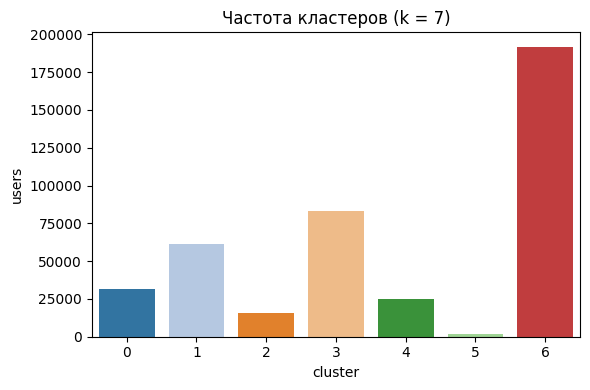

In [ ]:
# --- 5. Распределение пользователей по кластерам ---------------------------
cluster_counts = df["cluster"].value_counts().sort_index()
print("\nNum. users per cluster:")
print(cluster_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="tab20")
plt.title("Частота кластеров (k = 7)")
plt.xlabel("cluster"); plt.ylabel("users")
plt.tight_layout(); plt.show()

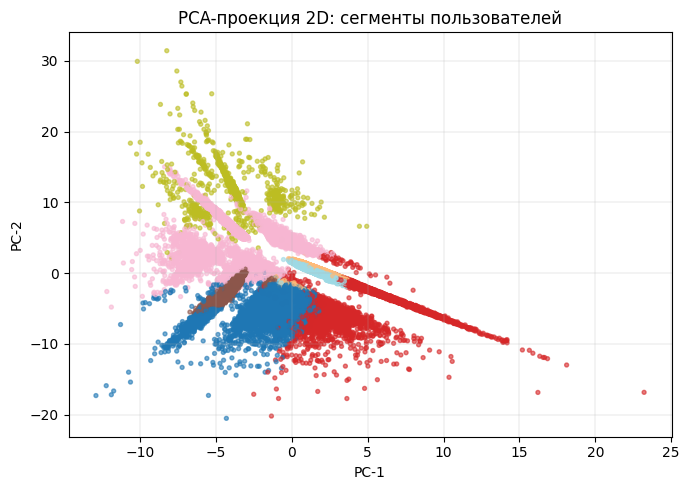

In [ ]:
# --- 6. 2-D визуализация (PCA → scatter) ------------------------------------
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_prep)           # (n_users, 2)

plt.figure(figsize=(7,5))
scatter = plt.scatter(coords[:,0], coords[:,1],
                      c=cluster_labels, cmap="tab20", s=8, alpha=0.6)
plt.title("PCA-проекция 2D: сегменты пользователей")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.grid(lw=0.2); plt.tight_layout()
plt.show()


In [ ]:
# --- 7. Быстрый «портрет» каждого сегмента (медианы чисел) ------------------
profile = (
    df.groupby("cluster")
      .median(numeric_only=True)
      .round(2)
)

print("\nCluster profile (numerical medians):")
display(profile)            # Jupyter-friendly; замените на print() при необходимости

profile.to_csv("/kaggle/working/profile.csv", encoding="utf-8")


Cluster profile (numerical medians):


,Unnamed: 0,id,age,loyalty_score,card_usage_score,total_deposits,closed_deposits,closed_ratio,deposits_0_3,deposits_4_6,deposits_7_12,deposits_12_plus,renewal_cnt_total,renewal_cnt_0_3,renewal_cnt_4_6,renewal_cnt_7_12,renewal_cnt_12_plus,renewal_amt_total,renewal_amt_0_3,renewal_amt_4_6,renewal_amt_7_12,renewal_amt_12_plus,sov_bal_total,sov_bal_0_3,sov_bal_4_6,sov_bal_7_12,sov_bal_12_plus,sov_traty_total,sov_traty_0_3,sov_traty_4_6,sov_traty_7_12,sov_traty_12_plus
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12.31,240204.0,40.0,5.0,16.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,6.40,5.30,5.3,0.0,0.0,8.01,6.91,6.91,0.00,0.00,4.80,3.71,3.71,0.00,0.00
1,12.23,302023.5,40.0,3.0,15.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.30,5.30,0.0,0.0,0.0,5.99,5.99,0.00,0.00,0.00,3.04,3.04,0.00,0.00,0.00
2,12.57,227761.5,41.0,5.0,16.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,7.09,7.09,0.0,0.0,0.0,8.79,8.70,0.00,0.00,0.00,5.33,5.30,0.00,0.00,0.00
3,11.81,279154.0,39.0,4.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.30,0.00,5.3,0.0,0.0,6.91,0.00,6.91,0.00,0.00,3.04,0.00,3.04,0.00,0.00
4,12.68,235668.0,41.0,4.0,14.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.71,0.00,0.0,5.3,0.0,6.91,0.00,0.00,6.91,0.00,3.22,0.00,0.00,3.04,0.00
5,12.37,167084.0,43.0,4.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,5.99,0.00,0.0,0.0,5.3,7.94,0.00,0.00,0.00,6.91,3.30,0.00,0.00,0.00,3.04
6,12.31,302748.5,39.0,4.0,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.30,5.30,0.0,0.0,0.0,6.91,6.91,0.00,0.00,0.00,3.04,3.04,0.00,0.00,0.00


In [ ]:
# ---------------------------------------------------------------
# отталкиваемся от уже обученного пайплайна `pipe`
# и DataFrame df, в котором есть колонка "cluster"
# ---------------------------------------------------------------
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)    # Показывать все столбцы
# ---------- 1.1  таблица центра (медиана/мода) -----------------
num_cols_all = [c for c in df.columns           # все числовые
                if df[c].dtype.kind in "if" and c not in ["cluster"]]
cat_cols     = ["gender_cd", "city_group"]

profile_num = (df.groupby("cluster")[num_cols_all]
                 .mean()
                 .round(1))

def mode_or_nan(s):
    return s.mode().iat[0] if not s.mode().empty else np.nan

profile_cat = (df.groupby("cluster")[cat_cols]
                 .agg(mode_or_nan))

cluster_profile = pd.concat([profile_num, profile_cat], axis=1)
display(cluster_profile)          # в Jupyter; иначе print()

profile.to_csv("/kaggle/working/profile_mean.csv", encoding="utf-8")

,Unnamed: 0,id,age,loyalty_score,card_usage_score,total_deposits,closed_deposits,closed_ratio,deposits_0_3,deposits_4_6,deposits_7_12,deposits_12_plus,renewal_cnt_total,renewal_cnt_0_3,renewal_cnt_4_6,renewal_cnt_7_12,renewal_cnt_12_plus,renewal_amt_total,renewal_amt_0_3,renewal_amt_4_6,renewal_amt_7_12,renewal_amt_12_plus,sov_bal_total,sov_bal_0_3,sov_bal_4_6,sov_bal_7_12,sov_bal_12_plus,sov_traty_total,sov_traty_0_3,sov_traty_4_6,sov_traty_7_12,sov_traty_12_plus,gender_cd,city_group
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12.3,240204.0,40.0,5.0,16.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,6.4,5.3,5.3,0.0,0.0,8.0,6.9,6.9,0.0,0.0,4.8,3.7,3.7,0.0,0.0,F,Россия
1,12.2,302023.5,40.0,3.0,15.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.3,5.3,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,F,Россия
2,12.6,227761.5,41.0,5.0,16.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,7.1,7.1,0.0,0.0,0.0,8.8,8.7,0.0,0.0,0.0,5.3,5.3,0.0,0.0,0.0,M,Россия
3,11.8,279154.0,39.0,4.0,15.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.3,0.0,5.3,0.0,0.0,6.9,0.0,6.9,0.0,0.0,3.0,0.0,3.0,0.0,0.0,F,Россия
4,12.7,235668.0,41.0,4.0,14.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5.7,0.0,0.0,5.3,0.0,6.9,0.0,0.0,6.9,0.0,3.2,0.0,0.0,3.0,0.0,F,Россия
5,12.4,167084.0,43.0,4.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,5.3,7.9,0.0,0.0,0.0,6.9,3.3,0.0,0.0,0.0,3.0,F,Россия
6,12.3,302748.5,39.0,4.0,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.3,5.3,0.0,0.0,0.0,6.9,6.9,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,F,Россия


In [ ]:
import numpy as np
import pandas as pd

# profile_num – медианы по кластерам (у вас уже есть)
# overall      – медианы по всей выборке (u вас есть)

# ❶ подменяем нули на NaN, чтобы не делить на 0
overall_safe = overall.replace(0, np.nan)

# ❷ считаем %-отклонение и убираем ±inf
delta = ((profile_num - overall_safe)
         .div(overall_safe) * 100)           # процент
delta = delta.replace([np.inf, -np.inf], np.nan)

# ❸ (опц.) показываем только «живые» столбцы
delta_clean = delta.dropna(axis=1, how="all")     # убирает колонки, где все NaN
display(delta_clean.round(1))


,Unnamed: 0,id,age,loyalty_score,card_usage_score,total_deposits,deposits_0_3,renewal_cnt_total,renewal_cnt_0_3,renewal_amt_total,renewal_amt_0_3,sov_bal_total,sov_bal_0_3,sov_traty_total,sov_traty_0_3
cluster,,,,,,,,,,,,,,,
0,0.6,-15.9,2.6,25.0,6.7,100.0,0.0,200.0,0.0,20.7,-0.1,15.8,30.1,57.7,21.5
1,-0.2,5.7,2.6,-25.0,0.0,0.0,0.0,0.0,0.0,-0.1,-0.1,-13.2,13.1,-1.5,-1.5
2,3.0,-20.3,5.1,25.0,6.7,300.0,300.0,500.0,500.0,33.9,33.9,27.4,64.0,74.1,74.1
3,-3.5,-2.3,0.0,0.0,0.0,0.0,-100.0,0.0,-100.0,-0.1,-100.0,-0.1,-100.0,-1.5,-100.0
4,3.8,-17.5,5.1,0.0,-6.7,0.0,-100.0,0.0,-100.0,7.5,-100.0,-0.1,-100.0,5.1,-100.0
5,1.4,-41.5,10.3,0.0,-13.3,0.0,-100.0,0.0,-100.0,13.1,-100.0,14.3,-100.0,8.4,-100.0
6,0.6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,-0.1,-0.1,30.1,-1.5,-1.5


In [ ]:
# --- 7. Профиль по каждому кластеру -----------------------------------------
# ➊ берем только числовые колонки (категориальные в One-Hot-E​ncoder’е теряются,
#    поэтому обычно анализируем именно числовые оригиналы)
num_cols_all = df.select_dtypes("number").columns.difference(["cluster", id_col])

# ➋ считаем среднее (центр кластера) и добавляем размер
cluster_profile = (
    df
      .groupby("cluster")[num_cols_all]       # среднее по каждому числовому признаку
      .mean()
      .round(1)                              # чуть округлим для читаемости
      .assign(n_users=df["cluster"].value_counts().sort_index())  # размер кластера
)

# ➌ вывод
print("\n=== Cluster profile (means + size) ===")
display(cluster_profile)          # Jupyter / Kaggle.  В обычном Python -> print()

cluster_profile.to_csv("/kaggle/working/cluster_profile.csv", encoding="utf-8")


=== Cluster profile (means + size) ===


,Unnamed: 0,age,card_usage_score,closed_deposits,closed_ratio,deposits_0_3,deposits_12_plus,deposits_4_6,deposits_7_12,loyalty_score,renewal_amt_0_3,renewal_amt_12_plus,renewal_amt_4_6,renewal_amt_7_12,renewal_amt_total,renewal_cnt_0_3,renewal_cnt_12_plus,renewal_cnt_4_6,renewal_cnt_7_12,renewal_cnt_total,sov_bal_0_3,sov_bal_12_plus,sov_bal_4_6,sov_bal_7_12,sov_bal_total,sov_traty_0_3,sov_traty_12_plus,sov_traty_4_6,sov_traty_7_12,sov_traty_total,total_deposits,n_users
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12.2,42.0,15.7,0.4,0.1,1.4,0.0,1.4,0.0,4.8,5.7,0.0,5.9,0.0,6.7,1.7,0.0,1.6,0.0,3.3,6.9,0.0,7.2,0.0,8.0,3.8,0.0,3.9,0.0,4.7,2.8,31360
1,11.9,41.7,14.5,1.1,1.0,1.2,0.0,0.0,0.0,3.8,5.6,0.0,0.1,0.0,5.6,1.5,0.0,0.0,0.0,1.5,6.3,0.0,0.1,0.0,6.3,3.3,0.0,0.0,0.0,3.3,1.2,61542
2,12.4,42.9,15.9,0.8,0.2,4.2,0.0,0.2,0.0,4.9,7.2,0.0,0.9,0.0,7.2,6.8,0.0,0.3,0.0,7.1,8.6,0.0,1.1,0.1,8.6,5.2,0.0,0.6,0.0,5.3,4.5,15742
3,11.7,41.2,14.5,0.2,0.2,0.0,0.0,1.1,0.0,4.1,0.0,0.0,5.6,0.0,5.7,0.0,0.0,1.3,0.0,1.3,0.0,0.0,6.5,0.0,6.5,0.0,0.0,3.4,0.0,3.4,1.1,83135
4,12.2,43.8,14.1,0.3,0.2,0.2,0.0,0.2,1.1,4.3,1.0,0.0,0.9,5.7,6.0,0.3,0.0,0.2,1.4,1.9,1.3,0.0,1.1,6.8,7.0,0.6,0.0,0.6,3.5,3.7,1.6,24889
5,12.0,45.5,13.4,0.2,0.1,0.3,1.1,0.2,0.1,4.7,1.1,5.8,0.9,0.5,6.1,0.3,1.3,0.2,0.2,2.0,1.4,7.0,1.2,0.7,7.3,0.7,3.3,0.6,0.3,3.7,1.7,1513
6,11.9,40.5,14.5,0.0,0.0,1.2,0.0,0.0,0.0,4.0,5.8,0.0,0.0,0.0,5.8,1.6,0.0,0.0,0.0,1.6,6.6,0.0,0.0,0.0,6.6,3.6,0.0,0.0,0.0,3.6,1.2,191712


In [ ]:
out_file_csv     = "users_with_clusters.csv"
out_file_parquet = "users_with_clusters.parquet"   # компактнее, быстрее читается

df.to_csv(out_file_csv, index=False, encoding="utf-8")
df.to_parquet(out_file_parquet, index=False)